# Training with Data Augmentation and some improving

The performances have been reduced from 63% to 56%.

I changed the learning rate to 0.0003.

I try to increase the number of raspberry samples, dubling it.

I will let the early stopping go for 15 epochs w.r.t. 10 that were set before.


In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Doubled the number of raspebrry in this dataset
!unzip ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/no_tomato_raspb_x2.zip

In [ ]:
%cd /content

/content


#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#Loading data & folder Exploring

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'no_tomato'

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

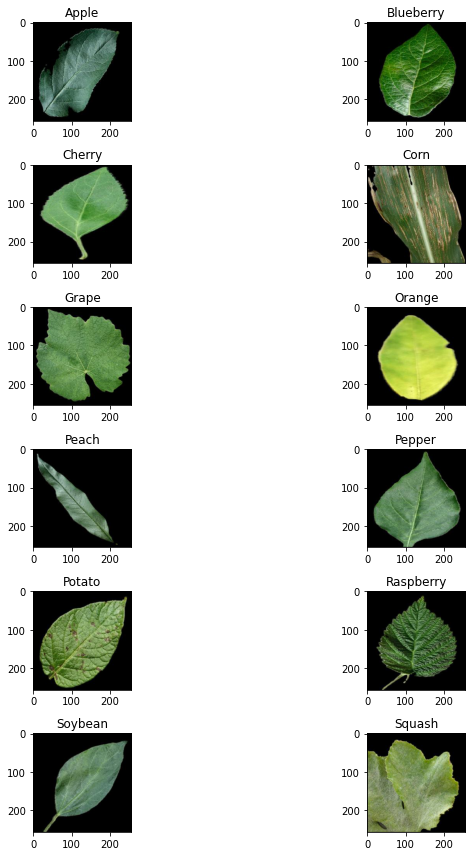

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))

for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


#Data Generator

Import:

In [ ]:
cd /content

/content


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
from random import randint

# Removed the function to change the background color 

# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rotation_range=180, height_shift_range=70, width_shift_range=120, zoom_range=0.6, horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0, rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)



Found 9220 images belonging to 13 classes.
Found 1799 images belonging to 13 classes.
Found 1214 images belonging to 13 classes.


#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

In [ ]:
# Model used:
#
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=13, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0003), metrics=[tf.keras.metrics.CategoricalAccuracy(), 'accuracy'])

    # Return the model
    return model

#Building Model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

# Save checkpoints

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Training the model

In [ ]:
noaug_callbacks = create_folders_and_callbacks(model_name='v2_DA_no_tomatooo')

# Create folders and callbacks and fit
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
577/577 [==============================] - ETA: 0s - loss: 2.0879 - categorical_accuracy: 0.3035 - accuracy: 0.3035

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 126s 189ms/step - loss: 2.0879 - categorical_accuracy: 0.3035 - accuracy: 0.3035 - val_loss: 1.7420 - val_categorical_accuracy: 0.4458 - val_accuracy: 0.4458
Epoch 2/200
577/577 [==============================] - ETA: 0s - loss: 1.5646 - categorical_accuracy: 0.4826 - accuracy: 0.4826

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 1.5646 - categorical_accuracy: 0.4826 - accuracy: 0.4826 - val_loss: 1.4760 - val_categorical_accuracy: 0.4919 - val_accuracy: 0.4919
Epoch 3/200
577/577 [==============================] - ETA: 0s - loss: 1.2890 - categorical_accuracy: 0.5727 - accuracy: 0.5727

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 1.2890 - categorical_accuracy: 0.5727 - accuracy: 0.5727 - val_loss: 1.2503 - val_categorical_accuracy: 0.5759 - val_accuracy: 0.5759
Epoch 4/200
577/577 [==============================] - ETA: 0s - loss: 1.0856 - categorical_accuracy: 0.6385 - accuracy: 0.6385

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 1.0856 - categorical_accuracy: 0.6385 - accuracy: 0.6385 - val_loss: 1.1671 - val_categorical_accuracy: 0.6126 - val_accuracy: 0.6126
Epoch 5/200
577/577 [==============================] - ETA: 0s - loss: 0.9831 - categorical_accuracy: 0.6732 - accuracy: 0.6732

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.9831 - categorical_accuracy: 0.6732 - accuracy: 0.6732 - val_loss: 0.9408 - val_categorical_accuracy: 0.6904 - val_accuracy: 0.6904
Epoch 6/200
577/577 [==============================] - ETA: 0s - loss: 0.8648 - categorical_accuracy: 0.7153 - accuracy: 0.7153

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.8648 - categorical_accuracy: 0.7153 - accuracy: 0.7153 - val_loss: 0.8770 - val_categorical_accuracy: 0.7037 - val_accuracy: 0.7037
Epoch 7/200
577/577 [==============================] - ETA: 0s - loss: 0.7991 - categorical_accuracy: 0.7377 - accuracy: 0.7377

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 186ms/step - loss: 0.7991 - categorical_accuracy: 0.7377 - accuracy: 0.7377 - val_loss: 1.0289 - val_categorical_accuracy: 0.6804 - val_accuracy: 0.6804
Epoch 8/200
577/577 [==============================] - ETA: 0s - loss: 0.7209 - categorical_accuracy: 0.7619 - accuracy: 0.7619

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.7209 - categorical_accuracy: 0.7619 - accuracy: 0.7619 - val_loss: 0.8200 - val_categorical_accuracy: 0.7276 - val_accuracy: 0.7276
Epoch 9/200
577/577 [==============================] - ETA: 0s - loss: 0.6431 - categorical_accuracy: 0.7875 - accuracy: 0.7875

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.6431 - categorical_accuracy: 0.7875 - accuracy: 0.7875 - val_loss: 0.5364 - val_categorical_accuracy: 0.8288 - val_accuracy: 0.8288
Epoch 10/200
577/577 [==============================] - ETA: 0s - loss: 0.5983 - categorical_accuracy: 0.8053 - accuracy: 0.8053

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.5983 - categorical_accuracy: 0.8053 - accuracy: 0.8053 - val_loss: 0.5557 - val_categorical_accuracy: 0.8255 - val_accuracy: 0.8255
Epoch 11/200
577/577 [==============================] - ETA: 0s - loss: 0.5524 - categorical_accuracy: 0.8175 - accuracy: 0.8175

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.5524 - categorical_accuracy: 0.8175 - accuracy: 0.8175 - val_loss: 0.4988 - val_categorical_accuracy: 0.8344 - val_accuracy: 0.8344
Epoch 12/200
577/577 [==============================] - ETA: 0s - loss: 0.5160 - categorical_accuracy: 0.8337 - accuracy: 0.8337

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.5160 - categorical_accuracy: 0.8337 - accuracy: 0.8337 - val_loss: 0.5697 - val_categorical_accuracy: 0.8193 - val_accuracy: 0.8193
Epoch 13/200
577/577 [==============================] - ETA: 0s - loss: 0.4842 - categorical_accuracy: 0.8397 - accuracy: 0.8397

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.4842 - categorical_accuracy: 0.8397 - accuracy: 0.8397 - val_loss: 0.4009 - val_categorical_accuracy: 0.8671 - val_accuracy: 0.8671
Epoch 14/200
577/577 [==============================] - ETA: 0s - loss: 0.4532 - categorical_accuracy: 0.8505 - accuracy: 0.8505

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.4532 - categorical_accuracy: 0.8505 - accuracy: 0.8505 - val_loss: 0.4343 - val_categorical_accuracy: 0.8610 - val_accuracy: 0.8610
Epoch 15/200
577/577 [==============================] - ETA: 0s - loss: 0.4422 - categorical_accuracy: 0.8561 - accuracy: 0.8561

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.4422 - categorical_accuracy: 0.8561 - accuracy: 0.8561 - val_loss: 0.5617 - val_categorical_accuracy: 0.8199 - val_accuracy: 0.8199
Epoch 16/200
577/577 [==============================] - ETA: 0s - loss: 0.4260 - categorical_accuracy: 0.8608 - accuracy: 0.8608

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.4260 - categorical_accuracy: 0.8608 - accuracy: 0.8608 - val_loss: 0.5099 - val_categorical_accuracy: 0.8549 - val_accuracy: 0.8549
Epoch 17/200
577/577 [==============================] - ETA: 0s - loss: 0.3850 - categorical_accuracy: 0.8754 - accuracy: 0.8754

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.3850 - categorical_accuracy: 0.8754 - accuracy: 0.8754 - val_loss: 0.4452 - val_categorical_accuracy: 0.8499 - val_accuracy: 0.8499
Epoch 18/200
577/577 [==============================] - ETA: 0s - loss: 0.4049 - categorical_accuracy: 0.8703 - accuracy: 0.8703

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.4049 - categorical_accuracy: 0.8703 - accuracy: 0.8703 - val_loss: 0.2955 - val_categorical_accuracy: 0.8922 - val_accuracy: 0.8922
Epoch 19/200
577/577 [==============================] - ETA: 0s - loss: 0.3560 - categorical_accuracy: 0.8866 - accuracy: 0.8866

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.3560 - categorical_accuracy: 0.8866 - accuracy: 0.8866 - val_loss: 0.2820 - val_categorical_accuracy: 0.9011 - val_accuracy: 0.9011
Epoch 20/200
577/577 [==============================] - ETA: 0s - loss: 0.3742 - categorical_accuracy: 0.8767 - accuracy: 0.8767

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.3742 - categorical_accuracy: 0.8767 - accuracy: 0.8767 - val_loss: 0.4789 - val_categorical_accuracy: 0.8516 - val_accuracy: 0.8516
Epoch 21/200
577/577 [==============================] - ETA: 0s - loss: 0.3514 - categorical_accuracy: 0.8841 - accuracy: 0.8841

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.3514 - categorical_accuracy: 0.8841 - accuracy: 0.8841 - val_loss: 0.6263 - val_categorical_accuracy: 0.8193 - val_accuracy: 0.8193
Epoch 22/200
577/577 [==============================] - ETA: 0s - loss: 0.3393 - categorical_accuracy: 0.8866 - accuracy: 0.8866

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.3393 - categorical_accuracy: 0.8866 - accuracy: 0.8866 - val_loss: 0.3985 - val_categorical_accuracy: 0.8605 - val_accuracy: 0.8605
Epoch 23/200
577/577 [==============================] - ETA: 0s - loss: 0.3009 - categorical_accuracy: 0.9016 - accuracy: 0.9016

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.3009 - categorical_accuracy: 0.9016 - accuracy: 0.9016 - val_loss: 0.2538 - val_categorical_accuracy: 0.9099 - val_accuracy: 0.9099
Epoch 24/200
577/577 [==============================] - ETA: 0s - loss: 0.3001 - categorical_accuracy: 0.9009 - accuracy: 0.9009

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.3001 - categorical_accuracy: 0.9009 - accuracy: 0.9009 - val_loss: 0.2732 - val_categorical_accuracy: 0.9172 - val_accuracy: 0.9172
Epoch 25/200
577/577 [==============================] - ETA: 0s - loss: 0.2902 - categorical_accuracy: 0.9034 - accuracy: 0.9034

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2902 - categorical_accuracy: 0.9034 - accuracy: 0.9034 - val_loss: 0.2884 - val_categorical_accuracy: 0.8977 - val_accuracy: 0.8977
Epoch 26/200
577/577 [==============================] - ETA: 0s - loss: 0.2860 - categorical_accuracy: 0.9039 - accuracy: 0.9039

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.2860 - categorical_accuracy: 0.9039 - accuracy: 0.9039 - val_loss: 0.3244 - val_categorical_accuracy: 0.8988 - val_accuracy: 0.8988
Epoch 27/200
577/577 [==============================] - ETA: 0s - loss: 0.2709 - categorical_accuracy: 0.9089 - accuracy: 0.9089

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2709 - categorical_accuracy: 0.9089 - accuracy: 0.9089 - val_loss: 0.4267 - val_categorical_accuracy: 0.8694 - val_accuracy: 0.8694
Epoch 28/200
577/577 [==============================] - ETA: 0s - loss: 0.2594 - categorical_accuracy: 0.9164 - accuracy: 0.9164

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.2594 - categorical_accuracy: 0.9164 - accuracy: 0.9164 - val_loss: 0.3192 - val_categorical_accuracy: 0.8994 - val_accuracy: 0.8994
Epoch 29/200
577/577 [==============================] - ETA: 0s - loss: 0.2560 - categorical_accuracy: 0.9149 - accuracy: 0.9149

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2560 - categorical_accuracy: 0.9149 - accuracy: 0.9149 - val_loss: 0.2000 - val_categorical_accuracy: 0.9311 - val_accuracy: 0.9311
Epoch 30/200
577/577 [==============================] - ETA: 0s - loss: 0.2388 - categorical_accuracy: 0.9208 - accuracy: 0.9208

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2388 - categorical_accuracy: 0.9208 - accuracy: 0.9208 - val_loss: 0.3949 - val_categorical_accuracy: 0.8844 - val_accuracy: 0.8844
Epoch 31/200
577/577 [==============================] - ETA: 0s - loss: 0.2376 - categorical_accuracy: 0.9230 - accuracy: 0.9230

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.2376 - categorical_accuracy: 0.9230 - accuracy: 0.9230 - val_loss: 0.1698 - val_categorical_accuracy: 0.9444 - val_accuracy: 0.9444
Epoch 32/200
577/577 [==============================] - ETA: 0s - loss: 0.2302 - categorical_accuracy: 0.9266 - accuracy: 0.9266

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.2302 - categorical_accuracy: 0.9266 - accuracy: 0.9266 - val_loss: 0.1596 - val_categorical_accuracy: 0.9483 - val_accuracy: 0.9483
Epoch 33/200
577/577 [==============================] - ETA: 0s - loss: 0.2339 - categorical_accuracy: 0.9225 - accuracy: 0.9225

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 107s 186ms/step - loss: 0.2339 - categorical_accuracy: 0.9225 - accuracy: 0.9225 - val_loss: 0.2264 - val_categorical_accuracy: 0.9339 - val_accuracy: 0.9339
Epoch 34/200
577/577 [==============================] - ETA: 0s - loss: 0.2171 - categorical_accuracy: 0.9286 - accuracy: 0.9286

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2171 - categorical_accuracy: 0.9286 - accuracy: 0.9286 - val_loss: 0.1828 - val_categorical_accuracy: 0.9433 - val_accuracy: 0.9433
Epoch 35/200
577/577 [==============================] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9241 - accuracy: 0.9241

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2313 - categorical_accuracy: 0.9241 - accuracy: 0.9241 - val_loss: 0.1581 - val_categorical_accuracy: 0.9483 - val_accuracy: 0.9483
Epoch 36/200
577/577 [==============================] - ETA: 0s - loss: 0.2115 - categorical_accuracy: 0.9305 - accuracy: 0.9305

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2115 - categorical_accuracy: 0.9305 - accuracy: 0.9305 - val_loss: 0.2218 - val_categorical_accuracy: 0.9366 - val_accuracy: 0.9366
Epoch 37/200
577/577 [==============================] - ETA: 0s - loss: 0.2050 - categorical_accuracy: 0.9337 - accuracy: 0.9337

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.2050 - categorical_accuracy: 0.9337 - accuracy: 0.9337 - val_loss: 0.1990 - val_categorical_accuracy: 0.9377 - val_accuracy: 0.9377
Epoch 38/200
577/577 [==============================] - ETA: 0s - loss: 0.2051 - categorical_accuracy: 0.9331 - accuracy: 0.9331

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2051 - categorical_accuracy: 0.9331 - accuracy: 0.9331 - val_loss: 0.1207 - val_categorical_accuracy: 0.9655 - val_accuracy: 0.9655
Epoch 39/200
577/577 [==============================] - ETA: 0s - loss: 0.1903 - categorical_accuracy: 0.9392 - accuracy: 0.9392

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1903 - categorical_accuracy: 0.9392 - accuracy: 0.9392 - val_loss: 0.3319 - val_categorical_accuracy: 0.8844 - val_accuracy: 0.8844
Epoch 40/200
577/577 [==============================] - ETA: 0s - loss: 0.2042 - categorical_accuracy: 0.9307 - accuracy: 0.9307

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.2042 - categorical_accuracy: 0.9307 - accuracy: 0.9307 - val_loss: 0.1773 - val_categorical_accuracy: 0.9450 - val_accuracy: 0.9450
Epoch 41/200
577/577 [==============================] - ETA: 0s - loss: 0.1970 - categorical_accuracy: 0.9359 - accuracy: 0.9359

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1970 - categorical_accuracy: 0.9359 - accuracy: 0.9359 - val_loss: 0.1331 - val_categorical_accuracy: 0.9583 - val_accuracy: 0.9583
Epoch 42/200
577/577 [==============================] - ETA: 0s - loss: 0.1966 - categorical_accuracy: 0.9357 - accuracy: 0.9357

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1966 - categorical_accuracy: 0.9357 - accuracy: 0.9357 - val_loss: 0.1294 - val_categorical_accuracy: 0.9600 - val_accuracy: 0.9600
Epoch 43/200
577/577 [==============================] - ETA: 0s - loss: 0.1937 - categorical_accuracy: 0.9373 - accuracy: 0.9373

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1937 - categorical_accuracy: 0.9373 - accuracy: 0.9373 - val_loss: 0.2677 - val_categorical_accuracy: 0.9222 - val_accuracy: 0.9222
Epoch 44/200
577/577 [==============================] - ETA: 0s - loss: 0.1867 - categorical_accuracy: 0.9387 - accuracy: 0.9387

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1867 - categorical_accuracy: 0.9387 - accuracy: 0.9387 - val_loss: 0.3202 - val_categorical_accuracy: 0.9233 - val_accuracy: 0.9233
Epoch 45/200
577/577 [==============================] - ETA: 0s - loss: 0.1778 - categorical_accuracy: 0.9421 - accuracy: 0.9421

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1778 - categorical_accuracy: 0.9421 - accuracy: 0.9421 - val_loss: 0.1415 - val_categorical_accuracy: 0.9505 - val_accuracy: 0.9505
Epoch 46/200
577/577 [==============================] - ETA: 0s - loss: 0.1762 - categorical_accuracy: 0.9407 - accuracy: 0.9407

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1762 - categorical_accuracy: 0.9407 - accuracy: 0.9407 - val_loss: 0.1344 - val_categorical_accuracy: 0.9655 - val_accuracy: 0.9655
Epoch 47/200
577/577 [==============================] - ETA: 0s - loss: 0.1792 - categorical_accuracy: 0.9405 - accuracy: 0.9405

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1792 - categorical_accuracy: 0.9405 - accuracy: 0.9405 - val_loss: 0.1430 - val_categorical_accuracy: 0.9561 - val_accuracy: 0.9561
Epoch 48/200
577/577 [==============================] - ETA: 0s - loss: 0.1743 - categorical_accuracy: 0.9433 - accuracy: 0.9433

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1743 - categorical_accuracy: 0.9433 - accuracy: 0.9433 - val_loss: 0.1368 - val_categorical_accuracy: 0.9644 - val_accuracy: 0.9644
Epoch 49/200
577/577 [==============================] - ETA: 0s - loss: 0.1785 - categorical_accuracy: 0.9423 - accuracy: 0.9423

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.1785 - categorical_accuracy: 0.9423 - accuracy: 0.9423 - val_loss: 0.1101 - val_categorical_accuracy: 0.9705 - val_accuracy: 0.9705
Epoch 50/200
577/577 [==============================] - ETA: 0s - loss: 0.1649 - categorical_accuracy: 0.9483 - accuracy: 0.9483

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.1649 - categorical_accuracy: 0.9483 - accuracy: 0.9483 - val_loss: 0.1299 - val_categorical_accuracy: 0.9578 - val_accuracy: 0.9578
Epoch 51/200
577/577 [==============================] - ETA: 0s - loss: 0.1747 - categorical_accuracy: 0.9437 - accuracy: 0.9437

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1747 - categorical_accuracy: 0.9437 - accuracy: 0.9437 - val_loss: 0.3667 - val_categorical_accuracy: 0.9077 - val_accuracy: 0.9077
Epoch 52/200
577/577 [==============================] - ETA: 0s - loss: 0.1572 - categorical_accuracy: 0.9495 - accuracy: 0.9495

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 188ms/step - loss: 0.1572 - categorical_accuracy: 0.9495 - accuracy: 0.9495 - val_loss: 0.1327 - val_categorical_accuracy: 0.9650 - val_accuracy: 0.9650
Epoch 53/200
577/577 [==============================] - ETA: 0s - loss: 0.1617 - categorical_accuracy: 0.9483 - accuracy: 0.9483

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1617 - categorical_accuracy: 0.9483 - accuracy: 0.9483 - val_loss: 0.1575 - val_categorical_accuracy: 0.9466 - val_accuracy: 0.9466
Epoch 54/200
577/577 [==============================] - ETA: 0s - loss: 0.1553 - categorical_accuracy: 0.9473 - accuracy: 0.9473

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1553 - categorical_accuracy: 0.9473 - accuracy: 0.9473 - val_loss: 0.2613 - val_categorical_accuracy: 0.9250 - val_accuracy: 0.9250
Epoch 55/200
577/577 [==============================] - ETA: 0s - loss: 0.1597 - categorical_accuracy: 0.9470 - accuracy: 0.9470

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.1597 - categorical_accuracy: 0.9470 - accuracy: 0.9470 - val_loss: 0.1366 - val_categorical_accuracy: 0.9639 - val_accuracy: 0.9639
Epoch 56/200
577/577 [==============================] - ETA: 0s - loss: 0.1467 - categorical_accuracy: 0.9537 - accuracy: 0.9537

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1467 - categorical_accuracy: 0.9537 - accuracy: 0.9537 - val_loss: 0.2018 - val_categorical_accuracy: 0.9400 - val_accuracy: 0.9400
Epoch 57/200
577/577 [==============================] - ETA: 0s - loss: 0.1432 - categorical_accuracy: 0.9539 - accuracy: 0.9539

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1432 - categorical_accuracy: 0.9539 - accuracy: 0.9539 - val_loss: 0.0766 - val_categorical_accuracy: 0.9750 - val_accuracy: 0.9750
Epoch 58/200
577/577 [==============================] - ETA: 0s - loss: 0.1559 - categorical_accuracy: 0.9509 - accuracy: 0.9509

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1559 - categorical_accuracy: 0.9509 - accuracy: 0.9509 - val_loss: 0.2223 - val_categorical_accuracy: 0.9477 - val_accuracy: 0.9477
Epoch 59/200
577/577 [==============================] - ETA: 0s - loss: 0.1394 - categorical_accuracy: 0.9555 - accuracy: 0.9555

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 188ms/step - loss: 0.1394 - categorical_accuracy: 0.9555 - accuracy: 0.9555 - val_loss: 0.1678 - val_categorical_accuracy: 0.9616 - val_accuracy: 0.9616
Epoch 60/200
577/577 [==============================] - ETA: 0s - loss: 0.1560 - categorical_accuracy: 0.9490 - accuracy: 0.9490

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1560 - categorical_accuracy: 0.9490 - accuracy: 0.9490 - val_loss: 0.1017 - val_categorical_accuracy: 0.9711 - val_accuracy: 0.9711
Epoch 61/200
577/577 [==============================] - ETA: 0s - loss: 0.1457 - categorical_accuracy: 0.9524 - accuracy: 0.9524

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 111s 193ms/step - loss: 0.1457 - categorical_accuracy: 0.9524 - accuracy: 0.9524 - val_loss: 0.0664 - val_categorical_accuracy: 0.9800 - val_accuracy: 0.9800
Epoch 62/200
577/577 [==============================] - ETA: 0s - loss: 0.1381 - categorical_accuracy: 0.9577 - accuracy: 0.9577

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1381 - categorical_accuracy: 0.9577 - accuracy: 0.9577 - val_loss: 0.1501 - val_categorical_accuracy: 0.9611 - val_accuracy: 0.9611
Epoch 63/200
577/577 [==============================] - ETA: 0s - loss: 0.1474 - categorical_accuracy: 0.9524 - accuracy: 0.9524

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 188ms/step - loss: 0.1474 - categorical_accuracy: 0.9524 - accuracy: 0.9524 - val_loss: 0.1024 - val_categorical_accuracy: 0.9722 - val_accuracy: 0.9722
Epoch 64/200
577/577 [==============================] - ETA: 0s - loss: 0.1436 - categorical_accuracy: 0.9549 - accuracy: 0.9549

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1436 - categorical_accuracy: 0.9549 - accuracy: 0.9549 - val_loss: 0.0709 - val_categorical_accuracy: 0.9767 - val_accuracy: 0.9767
Epoch 65/200
577/577 [==============================] - ETA: 0s - loss: 0.1283 - categorical_accuracy: 0.9555 - accuracy: 0.9555

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1283 - categorical_accuracy: 0.9555 - accuracy: 0.9555 - val_loss: 0.0755 - val_categorical_accuracy: 0.9767 - val_accuracy: 0.9767
Epoch 66/200
577/577 [==============================] - ETA: 0s - loss: 0.1443 - categorical_accuracy: 0.9520 - accuracy: 0.9520

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1443 - categorical_accuracy: 0.9520 - accuracy: 0.9520 - val_loss: 0.0792 - val_categorical_accuracy: 0.9750 - val_accuracy: 0.9750
Epoch 67/200
577/577 [==============================] - ETA: 0s - loss: 0.1271 - categorical_accuracy: 0.9581 - accuracy: 0.9581

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 191ms/step - loss: 0.1271 - categorical_accuracy: 0.9581 - accuracy: 0.9581 - val_loss: 0.2422 - val_categorical_accuracy: 0.9411 - val_accuracy: 0.9411
Epoch 68/200
577/577 [==============================] - ETA: 0s - loss: 0.1316 - categorical_accuracy: 0.9594 - accuracy: 0.9594

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 191ms/step - loss: 0.1316 - categorical_accuracy: 0.9594 - accuracy: 0.9594 - val_loss: 0.1424 - val_categorical_accuracy: 0.9639 - val_accuracy: 0.9639
Epoch 69/200
577/577 [==============================] - ETA: 0s - loss: 0.1297 - categorical_accuracy: 0.9610 - accuracy: 0.9610

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1297 - categorical_accuracy: 0.9610 - accuracy: 0.9610 - val_loss: 0.0554 - val_categorical_accuracy: 0.9844 - val_accuracy: 0.9844
Epoch 70/200
577/577 [==============================] - ETA: 0s - loss: 0.1278 - categorical_accuracy: 0.9586 - accuracy: 0.9586

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1278 - categorical_accuracy: 0.9586 - accuracy: 0.9586 - val_loss: 0.0660 - val_categorical_accuracy: 0.9811 - val_accuracy: 0.9811
Epoch 71/200
577/577 [==============================] - ETA: 0s - loss: 0.1292 - categorical_accuracy: 0.9594 - accuracy: 0.9594

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 108s 187ms/step - loss: 0.1292 - categorical_accuracy: 0.9594 - accuracy: 0.9594 - val_loss: 0.1170 - val_categorical_accuracy: 0.9717 - val_accuracy: 0.9717
Epoch 72/200
577/577 [==============================] - ETA: 0s - loss: 0.1325 - categorical_accuracy: 0.9572 - accuracy: 0.9572

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1325 - categorical_accuracy: 0.9572 - accuracy: 0.9572 - val_loss: 0.0921 - val_categorical_accuracy: 0.9711 - val_accuracy: 0.9711
Epoch 73/200
577/577 [==============================] - ETA: 0s - loss: 0.1145 - categorical_accuracy: 0.9649 - accuracy: 0.9649

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1145 - categorical_accuracy: 0.9649 - accuracy: 0.9649 - val_loss: 0.1552 - val_categorical_accuracy: 0.9611 - val_accuracy: 0.9611
Epoch 74/200
577/577 [==============================] - ETA: 0s - loss: 0.1194 - categorical_accuracy: 0.9603 - accuracy: 0.9603

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 188ms/step - loss: 0.1194 - categorical_accuracy: 0.9603 - accuracy: 0.9603 - val_loss: 0.0738 - val_categorical_accuracy: 0.9839 - val_accuracy: 0.9839
Epoch 75/200
577/577 [==============================] - ETA: 0s - loss: 0.1304 - categorical_accuracy: 0.9565 - accuracy: 0.9565

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1304 - categorical_accuracy: 0.9565 - accuracy: 0.9565 - val_loss: 0.1600 - val_categorical_accuracy: 0.9561 - val_accuracy: 0.9561
Epoch 76/200
577/577 [==============================] - ETA: 0s - loss: 0.1302 - categorical_accuracy: 0.9595 - accuracy: 0.9595

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1302 - categorical_accuracy: 0.9595 - accuracy: 0.9595 - val_loss: 0.1436 - val_categorical_accuracy: 0.9672 - val_accuracy: 0.9672
Epoch 77/200
577/577 [==============================] - ETA: 0s - loss: 0.1222 - categorical_accuracy: 0.9614 - accuracy: 0.9614

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1222 - categorical_accuracy: 0.9614 - accuracy: 0.9614 - val_loss: 0.0598 - val_categorical_accuracy: 0.9822 - val_accuracy: 0.9822
Epoch 78/200
577/577 [==============================] - ETA: 0s - loss: 0.1229 - categorical_accuracy: 0.9604 - accuracy: 0.9604

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 190ms/step - loss: 0.1229 - categorical_accuracy: 0.9604 - accuracy: 0.9604 - val_loss: 0.0699 - val_categorical_accuracy: 0.9805 - val_accuracy: 0.9805
Epoch 79/200
577/577 [==============================] - ETA: 0s - loss: 0.1242 - categorical_accuracy: 0.9625 - accuracy: 0.9625

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1242 - categorical_accuracy: 0.9625 - accuracy: 0.9625 - val_loss: 0.0536 - val_categorical_accuracy: 0.9833 - val_accuracy: 0.9833
Epoch 80/200
577/577 [==============================] - ETA: 0s - loss: 0.1183 - categorical_accuracy: 0.9611 - accuracy: 0.9611

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1183 - categorical_accuracy: 0.9611 - accuracy: 0.9611 - val_loss: 0.1287 - val_categorical_accuracy: 0.9678 - val_accuracy: 0.9678
Epoch 81/200
577/577 [==============================] - ETA: 0s - loss: 0.1182 - categorical_accuracy: 0.9615 - accuracy: 0.9615

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1182 - categorical_accuracy: 0.9615 - accuracy: 0.9615 - val_loss: 0.0441 - val_categorical_accuracy: 0.9867 - val_accuracy: 0.9867
Epoch 82/200
577/577 [==============================] - ETA: 0s - loss: 0.1167 - categorical_accuracy: 0.9628 - accuracy: 0.9628

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1167 - categorical_accuracy: 0.9628 - accuracy: 0.9628 - val_loss: 0.0672 - val_categorical_accuracy: 0.9805 - val_accuracy: 0.9805
Epoch 83/200
577/577 [==============================] - ETA: 0s - loss: 0.1258 - categorical_accuracy: 0.9595 - accuracy: 0.9595

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1258 - categorical_accuracy: 0.9595 - accuracy: 0.9595 - val_loss: 0.0861 - val_categorical_accuracy: 0.9789 - val_accuracy: 0.9789
Epoch 84/200
577/577 [==============================] - ETA: 0s - loss: 0.1270 - categorical_accuracy: 0.9604 - accuracy: 0.9604

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1270 - categorical_accuracy: 0.9604 - accuracy: 0.9604 - val_loss: 0.0590 - val_categorical_accuracy: 0.9811 - val_accuracy: 0.9811
Epoch 85/200
577/577 [==============================] - ETA: 0s - loss: 0.1171 - categorical_accuracy: 0.9615 - accuracy: 0.9615

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1171 - categorical_accuracy: 0.9615 - accuracy: 0.9615 - val_loss: 0.0901 - val_categorical_accuracy: 0.9711 - val_accuracy: 0.9711
Epoch 86/200
577/577 [==============================] - ETA: 0s - loss: 0.1272 - categorical_accuracy: 0.9625 - accuracy: 0.9625

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1272 - categorical_accuracy: 0.9625 - accuracy: 0.9625 - val_loss: 0.1914 - val_categorical_accuracy: 0.9383 - val_accuracy: 0.9383
Epoch 87/200
577/577 [==============================] - ETA: 0s - loss: 0.1153 - categorical_accuracy: 0.9649 - accuracy: 0.9649

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1153 - categorical_accuracy: 0.9649 - accuracy: 0.9649 - val_loss: 0.1091 - val_categorical_accuracy: 0.9717 - val_accuracy: 0.9717
Epoch 88/200
577/577 [==============================] - ETA: 0s - loss: 0.1067 - categorical_accuracy: 0.9651 - accuracy: 0.9651

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 191ms/step - loss: 0.1067 - categorical_accuracy: 0.9651 - accuracy: 0.9651 - val_loss: 0.0455 - val_categorical_accuracy: 0.9867 - val_accuracy: 0.9867
Epoch 89/200
577/577 [==============================] - ETA: 0s - loss: 0.1138 - categorical_accuracy: 0.9636 - accuracy: 0.9636

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1138 - categorical_accuracy: 0.9636 - accuracy: 0.9636 - val_loss: 0.0396 - val_categorical_accuracy: 0.9878 - val_accuracy: 0.9878
Epoch 90/200
577/577 [==============================] - ETA: 0s - loss: 0.1089 - categorical_accuracy: 0.9648 - accuracy: 0.9648

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1089 - categorical_accuracy: 0.9648 - accuracy: 0.9648 - val_loss: 0.0807 - val_categorical_accuracy: 0.9778 - val_accuracy: 0.9778
Epoch 91/200
577/577 [==============================] - ETA: 0s - loss: 0.1205 - categorical_accuracy: 0.9637 - accuracy: 0.9637

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1205 - categorical_accuracy: 0.9637 - accuracy: 0.9637 - val_loss: 0.0913 - val_categorical_accuracy: 0.9772 - val_accuracy: 0.9772
Epoch 92/200
577/577 [==============================] - ETA: 0s - loss: 0.1015 - categorical_accuracy: 0.9659 - accuracy: 0.9659

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1015 - categorical_accuracy: 0.9659 - accuracy: 0.9659 - val_loss: 0.1503 - val_categorical_accuracy: 0.9628 - val_accuracy: 0.9628
Epoch 93/200
577/577 [==============================] - ETA: 0s - loss: 0.1279 - categorical_accuracy: 0.9605 - accuracy: 0.9605

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 190ms/step - loss: 0.1279 - categorical_accuracy: 0.9605 - accuracy: 0.9605 - val_loss: 0.1559 - val_categorical_accuracy: 0.9594 - val_accuracy: 0.9594
Epoch 94/200
577/577 [==============================] - ETA: 0s - loss: 0.1162 - categorical_accuracy: 0.9612 - accuracy: 0.9612

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1162 - categorical_accuracy: 0.9612 - accuracy: 0.9612 - val_loss: 0.1149 - val_categorical_accuracy: 0.9717 - val_accuracy: 0.9717
Epoch 95/200
577/577 [==============================] - ETA: 0s - loss: 0.1203 - categorical_accuracy: 0.9629 - accuracy: 0.9629

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1203 - categorical_accuracy: 0.9629 - accuracy: 0.9629 - val_loss: 0.0441 - val_categorical_accuracy: 0.9855 - val_accuracy: 0.9855
Epoch 96/200
577/577 [==============================] - ETA: 0s - loss: 0.1058 - categorical_accuracy: 0.9656 - accuracy: 0.9656

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1058 - categorical_accuracy: 0.9656 - accuracy: 0.9656 - val_loss: 0.0856 - val_categorical_accuracy: 0.9767 - val_accuracy: 0.9767
Epoch 97/200
577/577 [==============================] - ETA: 0s - loss: 0.1238 - categorical_accuracy: 0.9615 - accuracy: 0.9615

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1238 - categorical_accuracy: 0.9615 - accuracy: 0.9615 - val_loss: 0.1468 - val_categorical_accuracy: 0.9611 - val_accuracy: 0.9611
Epoch 98/200
577/577 [==============================] - ETA: 0s - loss: 0.1129 - categorical_accuracy: 0.9661 - accuracy: 0.9661

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1129 - categorical_accuracy: 0.9661 - accuracy: 0.9661 - val_loss: 0.1063 - val_categorical_accuracy: 0.9717 - val_accuracy: 0.9717
Epoch 99/200
577/577 [==============================] - ETA: 0s - loss: 0.1133 - categorical_accuracy: 0.9677 - accuracy: 0.9677

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 190ms/step - loss: 0.1133 - categorical_accuracy: 0.9677 - accuracy: 0.9677 - val_loss: 0.1767 - val_categorical_accuracy: 0.9572 - val_accuracy: 0.9572
Epoch 100/200
577/577 [==============================] - ETA: 0s - loss: 0.1169 - categorical_accuracy: 0.9651 - accuracy: 0.9651

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 110s 190ms/step - loss: 0.1169 - categorical_accuracy: 0.9651 - accuracy: 0.9651 - val_loss: 0.1152 - val_categorical_accuracy: 0.9705 - val_accuracy: 0.9705
Epoch 101/200
577/577 [==============================] - ETA: 0s - loss: 0.0991 - categorical_accuracy: 0.9677 - accuracy: 0.9677

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.0991 - categorical_accuracy: 0.9677 - accuracy: 0.9677 - val_loss: 0.1797 - val_categorical_accuracy: 0.9516 - val_accuracy: 0.9516
Epoch 102/200
577/577 [==============================] - ETA: 0s - loss: 0.1084 - categorical_accuracy: 0.9675 - accuracy: 0.9675

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 190ms/step - loss: 0.1084 - categorical_accuracy: 0.9675 - accuracy: 0.9675 - val_loss: 0.0576 - val_categorical_accuracy: 0.9850 - val_accuracy: 0.9850
Epoch 103/200
577/577 [==============================] - ETA: 0s - loss: 0.1029 - categorical_accuracy: 0.9662 - accuracy: 0.9662

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1029 - categorical_accuracy: 0.9662 - accuracy: 0.9662 - val_loss: 0.0441 - val_categorical_accuracy: 0.9844 - val_accuracy: 0.9844
Epoch 104/200
577/577 [==============================] - ETA: 0s - loss: 0.1012 - categorical_accuracy: 0.9687 - accuracy: 0.9687

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/Checkpts/Check/v2_DA_no_tomatooo_Nov17_15-57-12/ckpts/cp.ckpt/assets


577/577 [==============================] - 109s 189ms/step - loss: 0.1012 - categorical_accuracy: 0.9687 - accuracy: 0.9687 - val_loss: 0.0893 - val_categorical_accuracy: 0.9750 - val_accuracy: 0.9750


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN/

/gdrive/MyDrive/Challenge1_Mio/others_no_tomato_CNN


In [ ]:
# Save best epoch model
model.save("Data_Augmentation_no_tomato_v33")

INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v33/assets


INFO:tensorflow:Assets written to: Data_Augmentation_no_tomato_v33/assets


#Plot training error and validation error

{'loss': [2.0878615379333496, 1.564603328704834, 1.2889984846115112, 1.085583209991455, 0.983099102973938, 0.8647657036781311, 0.7991120219230652, 0.7208542823791504, 0.6430970430374146, 0.5982522368431091, 0.5523902773857117, 0.5159749984741211, 0.4842412769794464, 0.453185111284256, 0.4422363042831421, 0.4259718954563141, 0.38499829173088074, 0.40492159128189087, 0.35599634051322937, 0.3742305338382721, 0.3514084815979004, 0.3393199145793915, 0.3009450137615204, 0.3001052439212799, 0.29017871618270874, 0.28600314259529114, 0.27085012197494507, 0.259401798248291, 0.2559727430343628, 0.23880238831043243, 0.23758937418460846, 0.2301904708147049, 0.2339017540216446, 0.2170547991991043, 0.23131567239761353, 0.21151776611804962, 0.20499280095100403, 0.2051076591014862, 0.1903333216905594, 0.20418404042720795, 0.19697882235050201, 0.19664140045642853, 0.1937320977449417, 0.18673017621040344, 0.17777450382709503, 0.1761692464351654, 0.1792357861995697, 0.17434078454971313, 0.1784786880016327

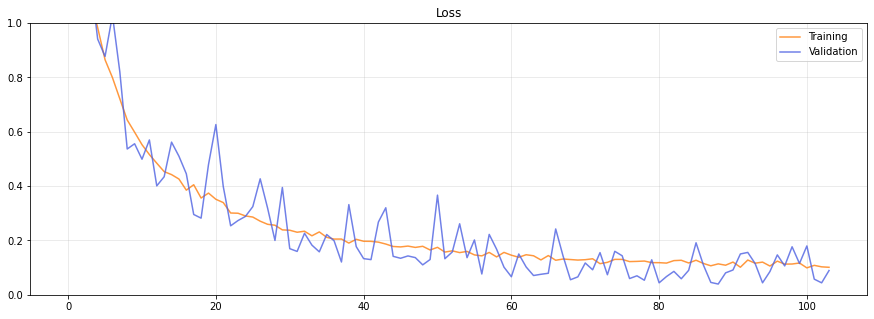

In [ ]:
print(history)
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Show predictions

In [ ]:
model_others = tfk.models.load_model("Data_Augmentation_no_tomato_v33")

In [ ]:
print(test_gen.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12}


In [ ]:
cd /content

/content


In [ ]:
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed)

Found 1214 images belonging to 13 classes.


In [ ]:
model_metrics = model_others.evaluate(test_gen, return_dict=True)
print(model_metrics)

1214/1214 [==============================] - 13s 5ms/step - loss: 0.0291 - categorical_accuracy: 0.9909 - accuracy: 0.9909
{'loss': 0.02905905619263649, 'categorical_accuracy': 0.9909390211105347, 'accuracy': 0.9909390211105347}


In [ ]:
print(model_metrics['categorical_accuracy'])
predictions = model_others.predict_generator(test_gen, steps=1214)


0.9909390211105347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
ok = [0]*15
error = [0]*15
good = [0]*15


for i in range(0, 1214):
  for k in range(0,13):
    if(predictions[i][k] == max(predictions[i])):
      if true_classes[i] == k:
        ok[k] += 1
      else:
        error[k] += 1
print("ok:", ok)
print("error:", error)
print("good:", good)

ok: [99, 47, 58, 120, 147, 174, 99, 75, 72, 27, 161, 55, 69, 0, 0]
error: [4, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
good: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   
print(true_classes)

[ 0  0  0 ... 12 12 12]


In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

       Apple       0.95      1.00      0.98        99
   Blueberry       1.00      1.00      1.00        47
      Cherry       1.00      0.98      0.99        59
        Corn       0.99      0.98      0.99       122
       Grape       0.98      1.00      0.99       147
      Orange       1.00      0.99      1.00       175
       Peach       0.98      1.00      0.99        99
      Pepper       1.00      0.96      0.98        78
      Potato       1.00      1.00      1.00        72
   Raspberry       1.00      1.00      1.00        27
     Soybean       1.00      0.99      1.00       162
      Squash       1.00      0.95      0.97        58
  Strawberry       1.00      1.00      1.00        69

    accuracy                           0.99      1214
   macro avg       0.99      0.99      0.99      1214
weighted avg       0.99      0.99      0.99      1214

